In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head(25)
train.shape

(1306122, 3)

In [4]:
train['period_count'] = train['question_text'].apply(lambda x: x.count("."))
train['word_length'] = train['question_text'].apply(lambda x: len(x.split(" ")))
train['char_length'] = train['question_text'].apply(lambda x: len(x))
train.head()

,qid,question_text,target,period_count,word_length,char_length
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,0,13,72
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,0,16,81
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,0,10,67
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,0,9,57
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,0,15,77


In [5]:
import collections
import statistics
import re


def train_score(train1):
  train1['word'] = train1['question_text'].apply(lambda x: [re.sub('[^A-Za-z0-9]+', '', i) for i in x.split(" ")])
  bad_word_dict=collections.Counter([y for x in train1['word'][train1['target']==1] for y in x])
  good_word_dict=collections.Counter([y for x in train1['word'][train1['target']==0] for y in x])
  total_word_dict=collections.Counter([y for x in train1['word'] for y in x])
  for i in total_word_dict:
      if i not in bad_word_dict:
          bad_word_dict[i] = -1
      if i not in good_word_dict:    
          good_word_dict[i] = 2
  raw_word_score = {i: (bad_word_dict[i]*good_word_dict[i])/
                    (total_word_dict[i]) for i in total_word_dict}
  raw_word_score_2 = {i: (bad_word_dict[i]-good_word_dict[i])/
                    (total_word_dict[i]) for i in total_word_dict}
  mean_score = statistics.mean(list(raw_word_score.values()))
  stdev = statistics.stdev(list(raw_word_score.values()))

  mean_score_2 = statistics.mean(list(raw_word_score_2.values()))
  stdev_2 = statistics.stdev(list(raw_word_score_2.values()))
  standard_word_score = {i : (raw_word_score[i]-mean_score)/stdev for i in raw_word_score}
  standard_word_score_2 = {i : (raw_word_score_2[i]-mean_score_2)/stdev_2 for i in raw_word_score_2}
  train1['score_1'] = train1['word'].apply(lambda x: sum([standard_word_score[i] for i in x]))
  train1['score_2'] = train1['word'].apply(lambda x: sum([standard_word_score_2[i] for i in x]))
  return train1.drop(columns = ["question_text","word","target"]),standard_word_score,standard_word_score_2


def test_score(test1,standard_word_score,standard_word_score_2):
  avg_1 = statistics.mean(list(standard_word_score.values()))
  avg_2 = statistics.mean(list(standard_word_score_2.values()))
  test1['word'] = test1['question_text'].apply(lambda x: [re.sub('[^A-Za-z0-9]+', '', i) for i in x.split(" ")])
  test1['score_1'] = test1['word'].apply(lambda x: sum([standard_word_score[i] if i in standard_word_score else avg_1 for i in x ]))
  test1['score_2'] = test1['word'].apply(lambda x: sum([standard_word_score_2[i] if i in standard_word_score_2 else avg_2 for i in x ]))
  return test1.drop(columns = ["question_text","word","target"])

In [0]:
train[train.target==1].score_1.hist(bins=400)
train[train.target==1].score_1.mean()
train[train.target==0].score_1.hist(bins=400)
train[train.target==0].score_1.mean()


In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
GradientBoostingClassifier, ExtraTreesClassifier)

cols=['question_text','target','period_count', 'word_length'] 
X=train[cols]
y=train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

X_train,score1,score2 = train_score(X_train)
X_test = test_score(X_test,score1,score2)

X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test),np.array(y_train),np.array(y_test)

logreg = LogisticRegression()
ranforest = RandomForestClassifier()
adaboo = AdaBoostClassifier()
GBC = GradientBoostingClassifier()
ETC = ExtraTreesClassifier

logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

logreg_feature = logreg.predict(X_train)


print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


/Users/royluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/royluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/royluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

Accuracy of logistic regression classifier on test set: 0.95


In [76]:
ranforest.fit(X_train, y_train)
y_pred_ranforest = ranforest.predict(X_test)

ranforest_feature = ranforest.predict(X_train)

print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(ranforest.score(X_test, y_test)))

/Users/royluo/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy of Random Forest classifier on test set: 0.95


In [77]:
adaboo.fit(X_train, y_train)
y_pred_adaboo = adaboo.predict(X_test)

adaboo_feature = adaboo.predict(X_train)

print('Accuracy of Ada Boost classifier on test set: {:.2f}'.format(adaboo.score(X_test, y_test)))

Accuracy of Ada Boost classifier on test set: 0.94


In [78]:
GBC.fit(X_train, y_train)
y_pred_GBC = GBC.predict(X_test)

GBC_feature = GBC.predict(X_train)

print('Accuracy of Gradient Boosting classifier on test set: {:.2f}'.format(GBC.score(X_test, y_test)))

Accuracy of Gradient Boosting classifier on test set: 0.95


In [1]:
gbm = xgb.XGBClassifier()

features_train = np.array([logreg_feature,ranforest_feature,adaboo_feature,GBC_feature])
features_test = np.array([y_pred_logreg,y_pred_ranforest,y_pred_adaboo,y_pred_GBC])
gbm.fit(features_train, y_train)
y_pred_gbm = gbm.predict(features_test)
f1_score(y_test, y_pred_gbm)

NameError: name 'xgb' is not defined

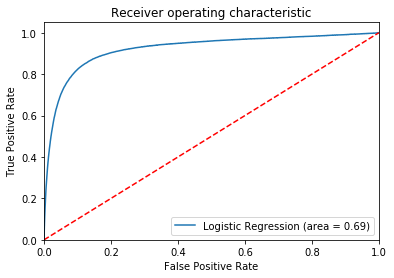

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    367711
           1       0.67      0.39      0.49     24126

   micro avg       0.95      0.95      0.95    391837
   macro avg       0.81      0.69      0.73    391837
weighted avg       0.94      0.95      0.94    391837



In [9]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.49429340019326695

In [49]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
cols=['question_text','target','period_count', 'word_length'] 
X=train[cols]
y=train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train,score1,score2 = train_score(X_train)
X_test = test_score(X_test,score1,score2)

/Users/royluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/royluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/royluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

In [50]:
model = tf.keras.models.Sequential()
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test),np.array(y_train),np.array(y_test)
rate = .3
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation = tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate, noise_shape=None, seed=None))
model.add(tf.keras.layers.Dense(32, activation = tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate, noise_shape=None, seed=None))
model.add(tf.keras.layers.Dense(32, activation = tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate, noise_shape=None, seed=None))
model.add(tf.keras.layers.Dense(32, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(2, activation = tf.nn.softmax))

model.compile(optimizer='adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])
model.fit(X_train,y_train,epochs = 2)

Epoch 1/2
1175509/1175509 [==============================] - 69s 59us/step - loss: 0.1568 - acc: 0.9500
Epoch 2/2
1175509/1175509 [==============================] - 75s 64us/step - loss: 0.1165 - acc: 0.9535


In [51]:
model.evaluate(X_test,y_test)
#returns [loss,accuracy]

130613/130613 [==============================] - 3s 19us/step


[0.15735252781007464, 0.9390030088893112]

In [52]:
predictions = model.predict_classes([X_test])
predictions[0]

0

In [53]:
from sklearn.metrics import f1_score
f1_score(y_test, predictions)

0.5693746283984649

In [11]:
glove = pd.read_table('glove.840B.300d.txt',header=None)

In [13]:
#glove['vector'] = glove[0].apply(lambda x : str(x).split(" ")[1:])
#glove['name'] = glove[0].apply(lambda x: str(x).split(" ")[0])
glove.head()

,0
0,", -0.082752 0.67204 -0.14987 -0.064983 0.05649..."
1,. 0.012001 0.20751 -0.12578 -0.59325 0.12525 0...
2,the 0.27204 -0.06203 -0.1884 0.023225 -0.01815...
3,and -0.18567 0.066008 -0.25209 -0.11725 0.2651...
4,to 0.31924 0.06316 -0.27858 0.2612 0.079248 -0...


In [ ]:
for i, chunk in enumerate(glove):
    single_df = chunk
    if i >0:
        break
single_df[0].str.split(' ', expand=True)
single_df.index = pd.Index(single_df[0])

In [ ]:
#glove_dict = {y[0]: y[1:] for i in glove[0] for y in [i.split(" ")]}
vals = glove.values
vecs = [{} for _ in range(5)]
for i, vec in enumerate(vals):
    vec = vec[0]
    splitted = vec.split()
    word = splitted[0]
    splitted[0] = 0
    vecs[i // 500000][word] = splitted
    if i % 10000 == 0:
        print(i)


In [ ]:
train['word'] = train['question_text'].apply(lambda x: [re.sub('[^A-Za-z0-9]+', '', i) for i in x.split(" ")])
test['word'] = test['question_text'].apply(lambda x: [re.sub('[^A-Za-z0-9]+', '', i) for i in x.split(" ")])
total_set = set([y for x in train.word for y in x].append([a for b in test.word for a in b]))
vals = glove.values
vec={}
for i, vec in enumerate(vals):
    vec = vec[0]
    splitted = vec.split()
    word = splitted[0]
    if word in total_set:
        vec{word:splitted[1:]}
        

In [101]:
paragram = pd.read_table("paragram_300_sl999.txt",header=None,encoding = "ISO-8859-1")

In [144]:
paragram = pd.read_table("paragram_300_sl999.txt",header=None,encoding = "ISO-8859-1")
#paragram_dict_1 = {y[0] : y[1:] for i in paragram_chunk_1 if y[0] in total_set for y in i.split()}


def choose_chunk(num,df):
    for i, chunk in enumerate(df):
        singledf = chunk
        if i >= num-1:
            break
    return singledf


train['word'] = train['question_text'].apply(lambda x: [re.sub('[^A-Za-z0-9]+', '', i) for i in x.split(" ")])
test['word'] = test['question_text'].apply(lambda x: [re.sub('[^A-Za-z0-9]+', '', i) for i in x.split(" ")])
total_set = set([y for x in train['word'] for y in x] + [a for b in test['word'] for a in b])

chunk_1 = paragram.loc[0:300000]
chunk_2 = paragram.loc[300000:600000]
chunk_3 = paragram.loc[600000:900000]
chunk_4 = paragram.loc[900000:1200000]
chunk_5 = paragram.loc[1200000:1500000]
chunk_6 = paragram.loc[1500000:]

def chunk_delete_useless(chunk,total_set):
    vec_dict={}
    vals = chunk.values
    for i, vec in enumerate(vals):
        vec = vec[0]
        splitted = vec.split()
        word = splitted[0]
        if word in total_set:
            vec_dict[word] = splitted[1:]
    return vec_dict
d1 = chunk_delete_useless(chunk_1,total_set)
d2 = chunk_delete_useless(chunk_2,total_set)
d3 = chunk_delete_useless(chunk_3,total_set)
d4 = chunk_delete_useless(chunk_4,total_set)
d5 = chunk_delete_useless(chunk_5,total_set)
d6 = chunk_delete_useless(chunk_6,total_set)
paragram_dict = {**d1,**d2,**d3,**d4,**d5,**d6}

In [62]:
question1 = input('Enter your question')
#question1 = 'Has the U.S become the largest dictatorship in this world?'
avg_1 = statistics.mean(list(score1.values()))
avg_2 = statistics.mean(list(score2.values()))

word_length = len(question1.split(' '))
char_length = len(question1)
period_count = question1.count('.')
word = [re.sub('[^A-Za-z0-9]+', '', i) for i in question1.split(" ")]
score_1 = sum([score1[i] if i in score1 else avg_1 for i in word ])
score_2 = sum([score2[i] if i in score2 else avg_2 for i in word ])

question_input = np.array([[period_count, word_length,score_1,score_2]])

model.predict_classes(question_input)

Enter your questionWhy do girls not prefer to become a physicist?	


array([0])

In [25]:
question_input

array([[  1.        ,  10.        , 633.92869895,  14.91558235]])

In [59]:
train[train.target == 1]

,qid,question_text,target,period_count,word_length,char_length
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1,0,11,67
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1,0,15,86
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1,0,15,102
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1,3,34,137
115,000537213b01fd77b58a,Which races have the smallest penis?,1,0,6,36
119,00056d45a1ce63856fc6,Why do females find penises ugly?,1,0,6,33
127,0005de07b07a17046e27,How do I marry an American woman for a Green C...,1,0,16,75
144,00068875d7c82a5bcf88,Why do Europeans say they're the superior race...,1,0,26,149
156,0006ffd99a6599ff35b3,Did Julius Caesar bring a tyrannosaurus rex on...,1,0,16,99
167,00075f7061837807c69f,In what manner has Republican backing of 'stat...,1,0,27,164


In [73]:
features_test = np.array([y_pred_logreg,y_pred_ranforest,y_pred_adaboo,y_pred_GBC])

In [74]:
features_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
from textblob import TextBlob
opinion = TextBlob("Do pakis smell of curry and shit?")
opinion.sentiment

Sentiment(polarity=-0.2, subjectivity=0.8)

In [4]:
opinion = TextBlob("Why is trump such a terrible and awful president.")
opinion.sentiment

Sentiment(polarity=-0.6666666666666666, subjectivity=0.8333333333333334)

In [43]:
feature = np.array([np.linspace(1,10,10),np.linspace(16,25,10),
                          np.linspace(91,100,10),np.linspace(28,37,10)])
y = np.random.randint(0,2,10)
model = xgb.XGBClassifier(objective= 'binary:logistic')
model.fit(feature,y)

XGBoostError: b'[20:50:06] src/objective/regression_obj.cu:66: Check failed: preds.Size() == info.labels_.Size() (4 vs. 10) labels are not correctly providedpreds.size=4, label.size=10\n\nStack trace returned 7 entries:\n[bt] (0) 0   libxgboost.dylib                    0x0000001a20f51b01 dmlc::StackTrace() + 305\n[bt] (1) 1   libxgboost.dylib                    0x0000001a20f5188f dmlc::LogMessageFatal::~LogMessageFatal() + 47\n[bt] (2) 2   libxgboost.dylib                    0x0000001a20fcf1ee xgboost::obj::RegLossObj<xgboost::obj::LogisticClassification>::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*) + 606\n[bt] (3) 3   libxgboost.dylib                    0x0000001a20f4d7d6 xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*) + 1014\n[bt] (4) 4   libxgboost.dylib                    0x0000001a20f6aaac XGBoosterUpdateOneIter + 172\n[bt] (5) 5   libffi.6.dylib                      0x000000010bf66884 ffi_call_unix64 + 76\n[bt] (6) 6   ???                                 0x00007ffee5991100 0x0 + 140732750434560\n\n'

In [30]:
np.random.randint(0,2,10)

array([1, 0, 0, 0, 0, 1, 1, 1, 0, 1])

In [35]:
feature = np.array([np.linspace(1,10,10).reshape(-1,1),np.linspace(16,25,10).reshape(-1,1),
                          np.linspace(91,100,10).reshape(-1,1),np.linspace(28,37,10).reshape(-1,1)])
feature

array([[[  1.],
        [  2.],
        [  3.],
        [  4.],
        [  5.],
        [  6.],
        [  7.],
        [  8.],
        [  9.],
        [ 10.]],

       [[ 16.],
        [ 17.],
        [ 18.],
        [ 19.],
        [ 20.],
        [ 21.],
        [ 22.],
        [ 23.],
        [ 24.],
        [ 25.]],

       [[ 91.],
        [ 92.],
        [ 93.],
        [ 94.],
        [ 95.],
        [ 96.],
        [ 97.],
        [ 98.],
        [ 99.],
        [100.]],

       [[ 28.],
        [ 29.],
        [ 30.],
        [ 31.],
        [ 32.],
        [ 33.],
        [ 34.],
        [ 35.],
        [ 36.],
        [ 37.]]])